In [1]:
# imports

In [2]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [3]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()



In [4]:
### Hyperparameters

In [5]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [6]:
### Environment

In [7]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

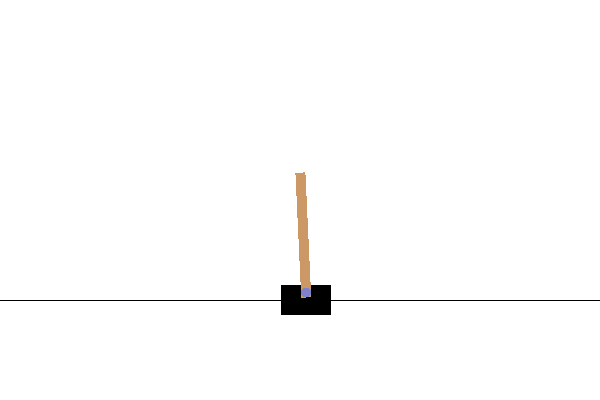

In [8]:
# env preview
#@test {"skip": true}
env.reset()
PIL.Image.fromarray(env.render())

In [9]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])


In [10]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [11]:
# action_spec() returns shape, dtype, name, and min/max values for actions
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In [12]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([ 0.01061065,  0.00118745, -0.02365191, -0.02122273], dtype=float32))
Next time step:
TimeStep(step_type=array(1, dtype=int32), reward=array(1., dtype=float32), discount=array(1., dtype=float32), observation=array([ 0.01063439,  0.19664046, -0.02407636, -0.32127327], dtype=float32))


In [13]:
# loading the enviro again as train and eval environments

In [14]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

In [15]:
# using the TF enviro wrapper to conver enviro's np arrays to tensors/

In [16]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [17]:
### Agent: Crating Q-Network

In [18]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# it's output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [19]:
### Agent: Init

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()



In [21]:
### Policy

In [22]:
# primary policy fr eval and deployment
eval_policy = agent.policy
# another policy, used for collecting (observations?)
collect_policy = agent.collect_policy

In [23]:
# below is an example of a policy made outside of an agent.
# it performs a random action with each step
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())


In [24]:
# we need this for the above
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('CartPole-v0'))

# this returns a policy step, a named tuple with three components:
# action (the one to be taken)
# state (could be used for stateful policies
# info (could be a log)
time_step = example_environment.reset()

# use to get an action from example policy
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>, state=(), info=())

In [25]:
### Evaluation Metrics
# A common metric for evaluating a policy is it's average reward
# several episodes are run, yielding an average

#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0
        
        # runs until out of steps
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics



In [26]:
# lets's run this on the random policy we made earlier.
# This provides a baseline of performance in this enviro
# given the hyperperameters
compute_avg_return(eval_env, random_policy, num_eval_episodes)

16.0

In [27]:
### Replay Buffer!

In [28]:
# holds data collected from enviro (obs?)
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    # specs for the data
    data_spec=agent.collect_data_spec,
    # HYPERPARAMETER
    batch_size=train_env.batch_size,
    # HYPERPARAMETER
    max_length=replay_buffer_max_length)

In [29]:
agent.collect_data_spec

Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)), action=BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))

In [30]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [31]:
### Collecting Data

In [32]:
# the below is a very common function in RL.
# what's going on is recording the data into the replay buffer

#@test {"skip": true}
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)

# This loop is so common in RL, that we provide standard implementations. 
# For more details see the drivers module.
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers

In [33]:
# Dataset generates trajectories with shape [Bx2x...]
# Ok, so this is creating a pipelie for feeding the buffer to the agent.
# we call it dataset, set it up, and then set it to be iterable (next celL)
# parralel calls and prefetch are optimizatons but idky
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


dataset

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


<PrefetchDataset shapes: (Trajectory(step_type=(64, 2), observation=(64, 2, 4), action=(64, 2), policy_info=(), next_step_type=(64, 2), reward=(64, 2), discount=(64, 2)), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(step_type=tf.int32, observation=tf.float32, action=tf.int64, policy_info=(), next_step_type=tf.int32, reward=tf.float32, discount=tf.float32), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [34]:
iterator = iter(dataset)
print(iterator)

In [35]:
### Training!
# in this step we must:
#- collect enviro data (obs?)
#- use that data to train the agents network

In [ ]:
#@test {"skip": true}
try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
    collect_data(train_env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

  # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    
    
# the below periodically prints the loss and average returns    
    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 200: loss = 114.49760437011719
step = 400: loss = 41.13872528076172
step = 600: loss = 36.06608581542969
step = 800: loss = 7.091083526611328
step = 1000: loss = 14.981706619262695
step = 1000: Average Return = 91.5
step = 1200: loss = 5.3616743087768555
step = 1400: loss = 19.496503829956055
step = 1600: loss = 171.44639587402344
step = 1800: loss = 223.86634826660156
step = 2000: loss = 54.937442779541016
step = 2000: Average Return = 90.30000305175781
step = 2200: loss = 270.31982421875
step = 2400: loss = 328.6573486328125
step = 2600: loss = 402.99639892578125
step = 2800: loss = 4387.9365234375
step = 3000: loss = 344.230712890625
step = 3000: Average Return = 81.9000015258789
step = 3200: loss = 215.78903198242188
step = 3400: loss = 335.4471

In [ ]:
### Visualizations

In [ ]:
#@test {"skip": true}

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

In [ ]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    # instantiates video (?)
    video = open(filename,'rb').read()
    # sets the encoder and encodes
    b64 = base64.b64encode(video)
    tag = '''
        <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4">
        Your browser does not support the video tag.
        </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)


In [ ]:
# "Now iterate through a few episodes of the Cartpole game with the agent.
# The underlying Python environment (the one "inside" the TensorFlow environment wrapper)
# provides a render() method, which outputs an image of the environment state.
# These can be collected into a video."

def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)




create_policy_eval_video(agent.policy, "trained-agent")

In [ ]:


create_policy_eval_video(random_policy, "random-agent")
